In [1]:
import csv
import pandas as pd
import geopandas as gpd
import osmnx as ox
from shapely import Point
from bng_latlon import OSGB36toWGS84

In [2]:
# Read Stops Naptan file
df_orig = pd.read_csv('Stops.csv', header=0, low_memory=False)
# Columns ATCOCode,NaptanCode,PlateCode,CleardownCode,CommonName,CommonNameLang,ShortCommonName,ShortCommonNameLang,Landmark,LandmarkLang,Street,StreetLang,Crossing,CrossingLang,Indicator,IndicatorLang,Bearing,NptgLocalityCode,LocalityName,ParentLocalityName,GrandParentLocalityName,Town,TownLang,Suburb,SuburbLang,LocalityCentre,GridType,Easting,Northing,Longitude,Latitude,StopType,BusStopType,TimingStatus,DefaultWaitTime,Notes,NotesLang,AdministrativeAreaCode,CreationDateTime,ModificationDateTime,RevisionNumber,Modification,Status

In [3]:
# Make a GeoDataFrame using the Longitude and Latitude fields
df = df_orig.copy()
df = df.drop(columns=['PlateCode','CleardownCode','Crossing','Suburb','LocalityCentre','StopType','GrandParentLocalityName','BusStopType','CommonNameLang','ShortCommonNameLang','LandmarkLang','StreetLang','CrossingLang','IndicatorLang','TownLang','SuburbLang','TimingStatus','DefaultWaitTime','Notes','NotesLang','CreationDateTime','ModificationDateTime','RevisionNumber','Modification'])
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_xy(df['Longitude'], df['Latitude']), crs=4326)

<Axes: >

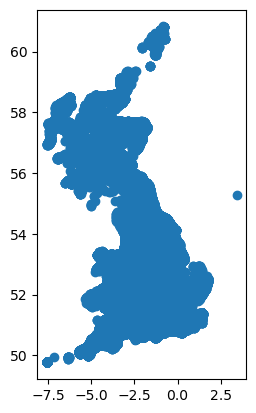

In [4]:
# Simple plot
gdf.plot()

In [5]:
# Display suspicious point
gdf[ (gdf['Longitude'] > 2.5)]

,ATCOCode,NaptanCode,CommonName,ShortCommonName,Landmark,Street,Indicator,Bearing,NptgLocalityCode,LocalityName,ParentLocalityName,Town,GridType,Easting,Northing,Longitude,Latitude,AdministrativeAreaCode,Status,geometry
375623,5710WDB48478,cditpjg,Penarth Heights,NaN,NaN,Arcot Street,not in use,N,E0035848,Penarth Moors,Cardiff,NaN,NaN,743237,611536,3.404267,55.278121,11,inactive,POINT (3.40427 55.27812)


In [6]:
# Check how many entries per local authority
df.ParentLocalityName.value_counts()

London           21864
Birmingham        5069
Sheffield         3542
Glasgow           3500
Leeds             3473
                 ...  
Yarford              1
Warmington           1
Barthomley           1
Woolstanwood         1
North Nesting        1
Name: ParentLocalityName, Length: 1850, dtype: int64

In [7]:
# Extract graph of Glasgow using OSMNX
Glasgow = ox.graph_from_place('Glasgow', network_type='drive')
Glasgow_proj = ox.project_graph(Glasgow, to_crs='epsg:3035') # using 3035 because it's metric

# Key geo is in fact Easting/Northing – for simplicity, here I use Lon/Lat, which doesn't have full coverage
dfGlasgow = df[df['ParentLocalityName']=="Glasgow"]
dfGlasgow =  dfGlasgow[~dfGlasgow['Longitude'].isna()]
dfGlasgow.reset_index(inplace=True,drop=True)
gdfGlasgow = gpd.GeoDataFrame(dfGlasgow, geometry=gpd.GeoSeries.from_xy(dfGlasgow['Longitude'], dfGlasgow['Latitude']), crs='epsg:3035')

In [8]:
# Find stops that are at least 10 metres away from a road, using Lon/Lat ()
gdftouse = gdfGlasgow
graph = Glasgow_proj

# for row in range(len(gdftouse)):
for row in range(100):
    
    lon = gdftouse.at[row, 'Longitude']
    lat = gdftouse.at[row, 'Latitude']
    
    point = lat, lon

    G = ox.graph_from_point(point, network_type='drive')
    Gp = ox.project_graph(G)
    point_geom_proj, crs = ox.projection.project_geometry(Point(reversed(point)), to_crs=Gp.graph['crs'])
    
    x, y = point_geom_proj.x, point_geom_proj.y
    nearest = ox.nearest_edges(Gp, x, y, return_dist=True)
    if (int(nearest[0][1]) > 10):
        print(gdftouse.at[row, 'ATCOCode'] + " " + str(nearest))

9100ALXPD ((27432018, 27432022, 0), 15.510528195359685)
9100ANSL ((86873440, 289767929, 0), 32.86422400972587)
9100ASFIELD ((263679063, 263679059, 0), 10.600554772698116)
9100BALISTN ((749883364, 778425769, 0), 37.11927753808497)
9100BLGRVE ((27437069, 28096025, 0), 55.71026933270662)
9100BNHL ((338716228, 295026202, 0), 23.121385244014373)
9100BRIDGTN ((30039549, 94610187, 0), 14.6442920784617)
9100CARMYLE ((289895757, 2096433672, 0), 75.23439203465473)
9100CCRT ((986404011, 8763806081, 0), 34.1202391305199)
9100CDNL ((77895651, 77895656, 0), 9.948066817973286)
9100CFFT ((262841270, 262841518, 0), 59.653235513847314)
9100CKHL ((6605901604, 60676358, 0), 46.92661116164154)
9100CNTY ((581076901, 270384239, 0), 29.692528874358064)
9100CROKSTN ((33725705, 29107370, 0), 27.87283952901534)
9100CROSSHL ((450849971, 450849967, 0), 26.94564590486191)
9100CRSMYLF ((28783706, 2202399156, 0), 29.754153016205457)
9100DAWSHLM ((2913998, 60038020, 0), 23.64201286277117)
9100DLMRNOK ((263247738, 1662

In [9]:
# Here we'll use Easting and Northings - Extract graph of London using OSMNX
London = ox.graph_from_place('London', network_type='drive')
London_proj = ox.project_graph(London, to_crs='epsg:3035') # using 3035 because it's metric

# Differently from Glasgow, we don't filter missing Lat/Lon, as we'll be using directly Easting and Northing
dfLondon = df[df['ParentLocalityName']=="London"]
dfLondon.reset_index(inplace=True,drop=True)
#gdfLondon = gpd.GeoDataFrame(dfLondon, geometry=gpd.GeoSeries.from_xy(dfLondon['Longitude'], dfLondon['Latitude']), crs='epsg:3035')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

dftouse = dfLondon
graph = London

for row in range(100):
    
    north = dftouse.at[row, 'Northing']
    east = dftouse.at[row, 'Easting']


    point = OSGB36toWGS84(east,north)
    
    G = ox.graph_from_point(point, network_type='drive')
    Gp = ox.project_graph(G)
    point_geom_proj, crs = ox.projection.project_geometry(Point(reversed(point)), to_crs=Gp.graph['crs'])
    
    x, y = point_geom_proj.x, point_geom_proj.y
    nearest = ox.nearest_edges(Gp, x, y, return_dist=True)    
    print(dftouse.at[row, 'ATCOCode'], str(nearest))

150008920N ((537998794, 2837722589, 0), 4.786108525527913)
150008920S ((25736047, 227255988, 0), 0.9341930839584597)
150008930 ((8629273304, 691344793, 0), 2.77046962249442)
150022010003 ((227262167, 227263550, 0), 2.8777268386982797)
1500220100Y3 ((227262167, 227263550, 0), 3.434967500413884)
150042025008 ((321513055, 25640062, 0), 2.9607923964025122)
1500420250Y8 ((321513055, 25640062, 0), 2.6919293727594757)
1500624 ((691344790, 691344776, 0), 0.7856275317702552)
1500IM383 ((691344776, 25742903, 0), 2.5426054670577916)
1500IM383B ((691344776, 25742903, 0), 4.1995178952884515)
210021002015 ((29439241, 29439192, 0), 6.6519766661858615)
210021002020 ((257898240, 195769, 0), 11.491960104678908)
210021002030 ((29439121, 29439206, 0), 2.942133842837757)
210021002040 ((257894782, 257804763, 0), 15.34872405298859)
210021002060 ((257804022, 29438824, 0), 7.700797032411415)
210021002090 ((28921032, 28921034, 0), 7.117614724111225)
210021002135 ((2249172873, 1020717147, 0), 4.27982214548341)
2